In [9]:
import numpy as np
import pandas as pd
import os
import glob
import unicodedata
import nltk
import re
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.cm as cm
from matplotlib import rcParams
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import pandas
import seaborn as sns 
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sp
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

nltk.download('punkt')
nltk.download('omw')
nltk.download('wordnet')
nltk.download('stopwords')

review_col = "review_description"
rating_col = "rating"


df = pd.read_excel('train.xlsx')

print(df.head(10))

stopwords_list_arabic = stopwords.words('arabic')
# stopwords_list_english = stopwords.words('english')
print(stopwords_list_arabic,'\n')


ModuleNotFoundError: No module named 'tensorflow'

In [5]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)


def remove_emojis(text):
  return ''.join(c for c in text if not unicodedata.combining(c))

def is_english_word(word) :
    alpha = "abcdefghijklmnopqrtuvwxyz"
    for i in word:
        if i in alpha :
            return True
    return False


def remove_punctuations(word):
    arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
    english_punctuations = string.punctuation
    punctuations_list = arabic_punctuations + english_punctuations
    translator = str.maketrans('', '', punctuations_list)
    return word.translate(translator)


def preprocess_review(sentence):
    
    words = wordpunct_tokenize(sentence)
    non_english_words = [word for word in words if not is_english_word(word)]
    cleaned_sentence = ' '.join(non_english_words)
    
    cleaned_sentence = remove_emojis(cleaned_sentence)
    cleaned_sentence = normalize_arabic(cleaned_sentence)
    cleaned_sentence = remove_repeating_char(cleaned_sentence)
    cleaned_sentence = remove_punctuations(cleaned_sentence)
    
    return cleaned_sentence

def preprocess_dataframe(df, review_col=review_col):
    tokenizer = RegexpTokenizer(r'\w+')
    df[review_col] = df[review_col].apply(preprocess_review)
    df[review_col] = df[review_col].apply(tokenizer.tokenize)
    df[review_col] = df[review_col].apply(lambda x: [item for item in x if item not in stopwords_list_arabic])



In [6]:
# print(df.head(30))
preprocess_dataframe(df);
print(df.head(30))


                                   review_description  rating
0   [شركه, زباله, سواقين, بتبرشم, مفيش, حتي, رقم, ...      -1
1   [خدمه, الدفع, طريق, الكي, نت, توقفت, عندي, اصب...       1
2   [تطبيق, غبي, جاري, حذفه, عاملين, اكواد, خصم, ن...      -1
3   [فعلا, تطبيق, متاز, امكانيه, يتيح, لمستخدم, ال...       1
4   [سيء, جدا, اسعار, رسوم, التوصيل, تمت, لواقع, صله]      -1
5   [قعد, سنه, يدور, علي, سائق, اما, توصيل, الاشيا...       0
6                                       [احلئ, تطبيق]       1
7                                        [رائع, مدهش]       1
8   [مکو, البحرین, وعمان, وغیره, العراق, مکو, یعنی...      -1
9                  [تطبيق, جميل, يستاهل, الخمس, نجوم]       1
10                                            [طلبات]       1
11                         [الاسمر, عمار, الريق, مصر]       1
12  [متاز, ومصدقه, ودقه, وسرعه, التوصيل, الرجاء, و...       1
13                                  [هالبرنامج, منقذ]       1
14             [مره, سريع, جاني, الطلب, انصح, بصراحه]       1
15      

Length of 'positive' column Before: 19189
Length of 'negative' column Before: 11340
Length of 'neutral' column Before: 1507
100795 total words in positive, with a vocabulary size of 17451


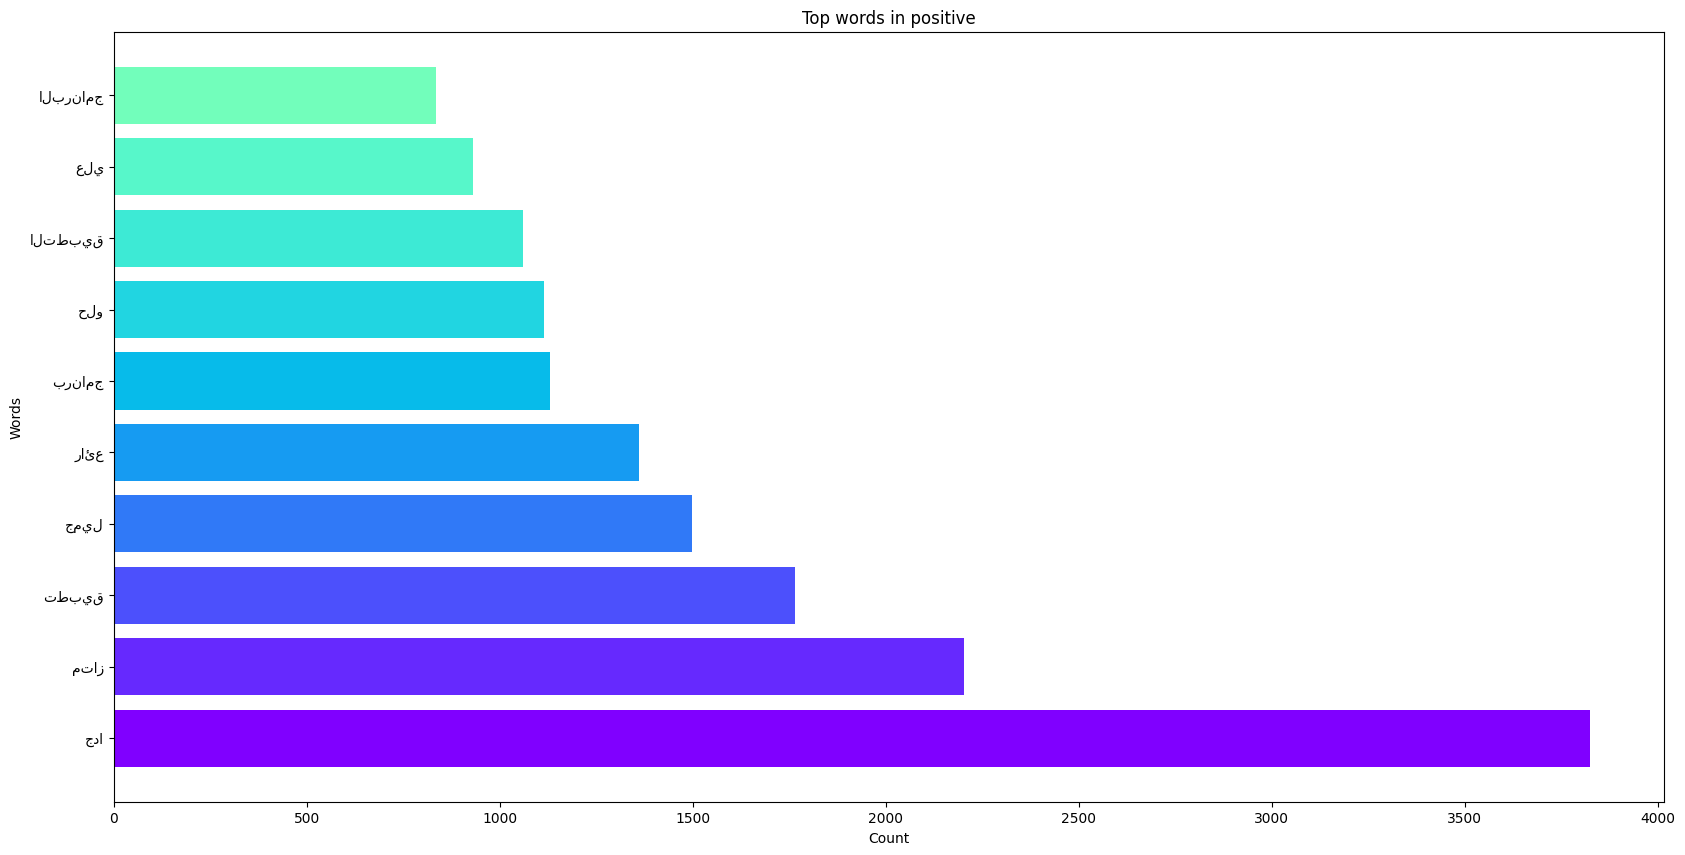

13881 total words in neutral, with a vocabulary size of 4919


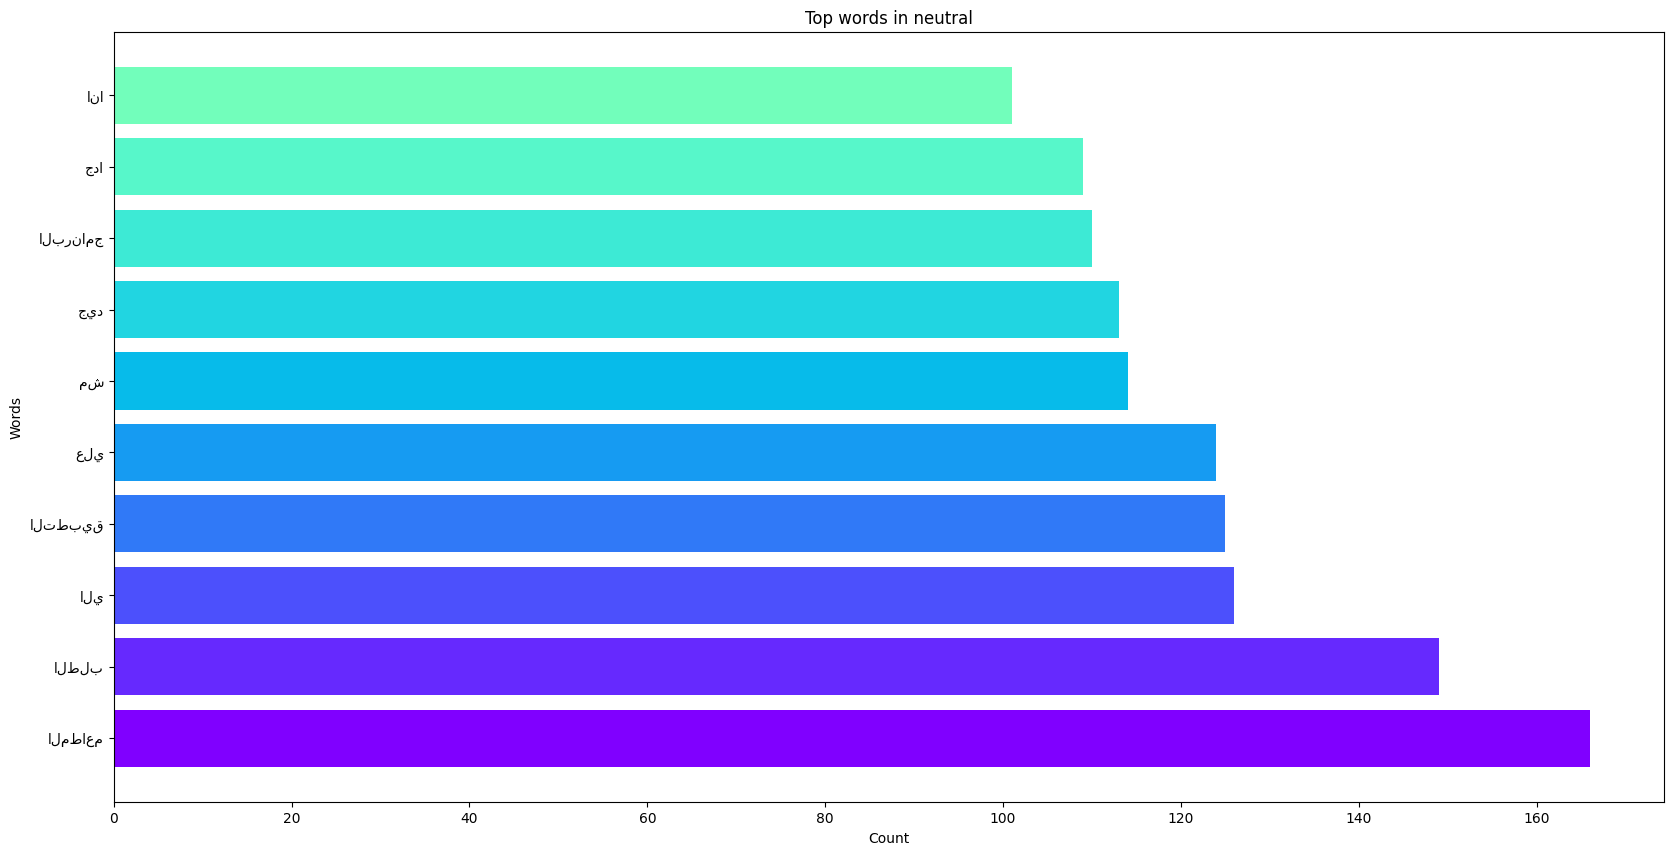

132033 total words in negative, with a vocabulary size of 22291


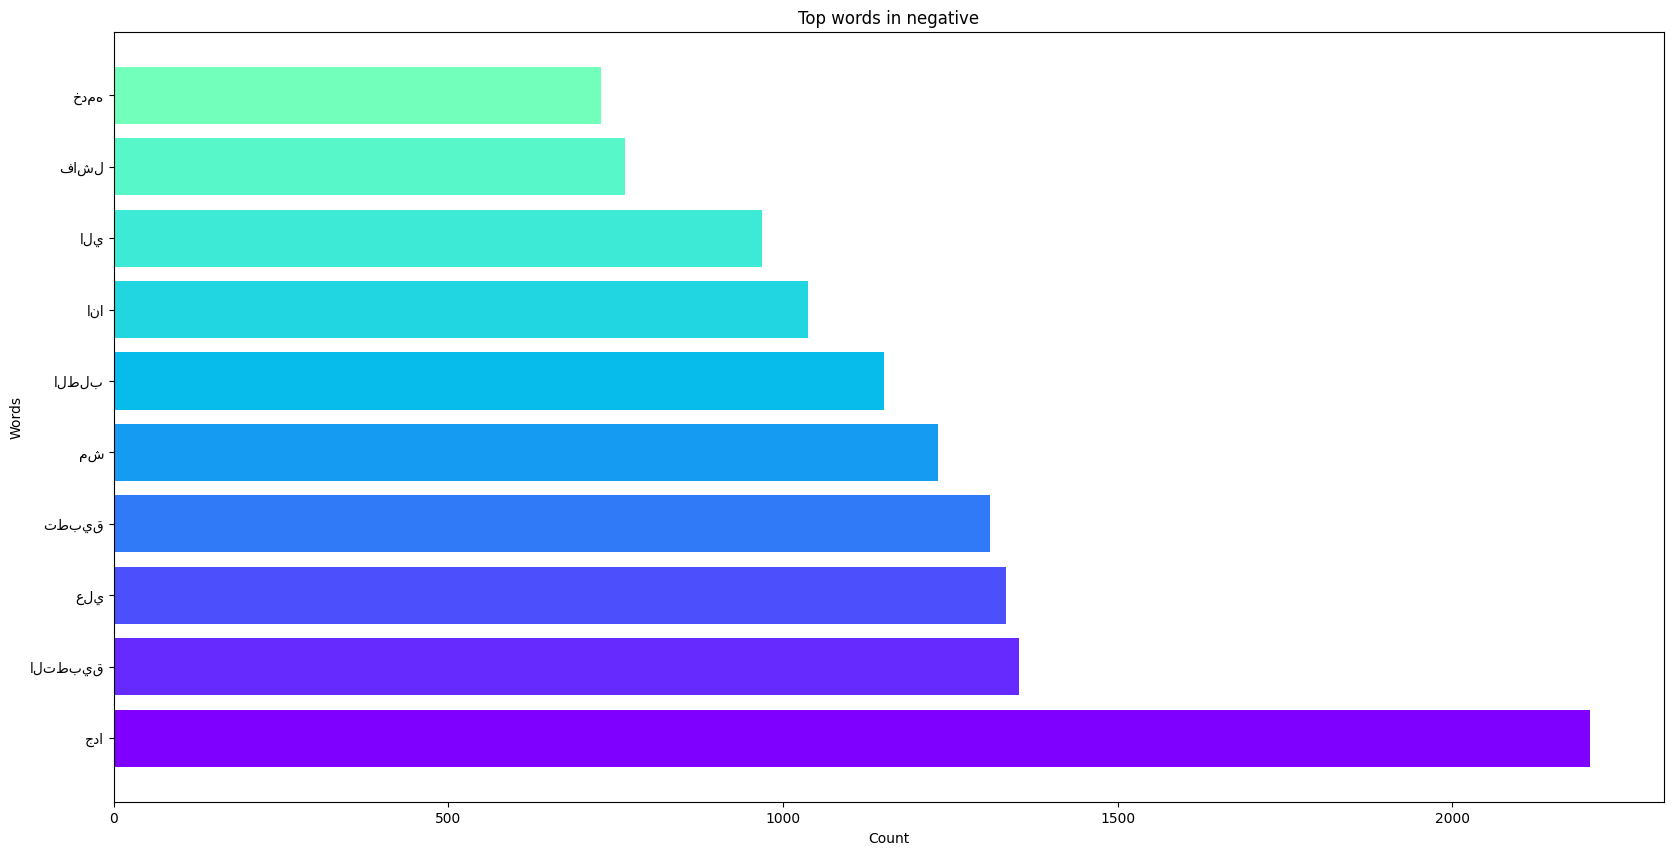

In [7]:
pos = []
neg = []
neu = []

df[rating_col] = df[rating_col].replace({-1: 0, 0: 1, 1: 2})

for i in range(len(df[rating_col])) : 
    if df[rating_col][i] == 1:
        neu.append(df[review_col][i])

    if df[rating_col][i] == 2:
        pos.append(df[review_col][i])

    if df[rating_col][i] == 0:
        neg.append(df[review_col][i])



# Display the updated DataFrame Before
print(f"Length of 'positive' column Before: {len(pos)}")
print(f"Length of 'negative' column Before: {len(neg)}")
print(f"Length of 'neutral' column Before: {len(neu)}")

def display_stats(col,col_name):
    all_words = []

    for sentence in col :
        for word in sentence :
            all_words.append(word)

    VOCAB = sorted(list(set(all_words)))

    print(f"%s total words in {col_name}, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

    counter = Counter(all_words)
    counter.most_common(35)


    counted_words = Counter(all_words)

    words = []
    counts = []
    for letter, count in counted_words.most_common(10):
        words.append(letter)
        counts.append(count)

    colors = cm.rainbow(np.linspace(0, 1, 20))
    rcParams['figure.figsize'] = 20, 10

    plt.title('Top words in ' + col_name)
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.barh(words, counts, color=colors)
    plt.show()



for col in [(pos,"positive"), (neu,"neutral"), (neg,"negative")]:
    display_stats(col[0] ,col[1] )

In [231]:
# Create new columns 'positive', 'negative', and 'neutral' based on the 'rating' column
# Identify the two minimum lengths
min_lengths = sorted([len(pos), len(neg), len(neu)])[:2]


num_duplicates = max(min_lengths) - len(neu)
duplicated_rows = df[df[rating_col] == 1].sample(n=num_duplicates, replace=True)
df = pd.concat([df, duplicated_rows], ignore_index=True)


# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the updated DataFrame After
print(f"Length of 'positive' column After: {len(df[df[rating_col]== 2])}")
print(f"Length of 'negative' column After: {len(df[df[rating_col] == 0])}")
print(f"Length of 'neutral' column After: {len(df[df[rating_col] == 1])}")

print(df.head(20))

Length of 'positive' column After: 19189
Length of 'negative' column After: 11340
Length of 'neutral' column After: 11340
                                   review_description  rating
0                                         [مره, كيوت]     1.0
1                                        [خلال, ساعه]     2.0
2          [صراحه, انكت, تريد, اكل, اطلب, وبس, يﻷتيك]     2.0
3                       [اعجبني, جدا, واستخدمه, اجوع]     2.0
4   [طلبت, كيلو, كفته, محل, الصواف, ولم, يصل, وكتب...     0.0
5      [غالي, واقل, شيء, لطلب, 30, تقدر, تلغي, الطلب]     1.0
6                          [مش, حلو, خالص, زي, الزفت]     0.0
7   [التطبيق, باختصار, المطاعم, الي, بتدعي, ان, ال...     1.0
8   [شي, حلو, عندي, ملاحظه, صغيره, وقت, الوصول, لا...     2.0
9                                       [كطكطكخطدكدك]     1.0
10                [اصبح, سيئ, ومتعب, لايفتح, التطبيق]     0.0
11                              [البرنامج, جدا, مفيد]     2.0
12                                             [حلوه]     2.0
13  [اسعار